In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D, Embedding, TextVectorization, GlobalAveragePooling1D
from tensorflow.keras.metrics import Precision, Recall, AUC





In [2]:
data = pd.read_csv('airline_sentiment_analysis.csv', index_col=0)
data.head()

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [3]:
data['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [4]:
# Mapping sentiment values to numerical values
data['sentiment'] = data['airline_sentiment'].map({'positive':1, 'negative':0})

In [5]:
data.head()

,airline_sentiment,text,sentiment
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [6]:
# Tokenizing the text 
token = Tokenizer()
token.fit_on_texts(data['text'])
tokenized_text = token.texts_to_sequences(data['text'])

# Padding the tokenized text so that they are all the same lengths
# finding the length of the longest text to set as max length of padding
longest = max(len(l) for l in tokenized_text) 
padded_tokenized_text = pad_sequences(tokenized_text, maxlen=longest).tolist()

In [7]:
# Adding tokenized text to the df
data['tokenized_text'] = padded_tokenized_text
data.head()

,airline_sentiment,text,sentiment,tokenized_text
1,positive,@VirginAmerica plus you've added commercials t...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,negative,@VirginAmerica it's really aggressive to blast...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,negative,@VirginAmerica and it's a really big bad thing...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 3..."
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
# Splitting into training and testing data
training_data = data.sample(frac=0.8, random_state=1)
testing_data = data.drop(training_data.index)

In [9]:
# Trying new model
encoder = TextVectorization(
    max_tokens = 10000, standardize = 'lower_and_strip_punctuation',
    output_mode = 'int', output_sequence_length = 200,
)

encoder.adapt(training_data['text'].to_numpy())

2022-07-16 15:15:05.608802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model = Sequential()
model.add(encoder)
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero=True))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[Precision(), Recall(), AUC()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [11]:
hist = model.fit(training_data['text'], training_data['sentiment'],
                    validation_split=0.2, epochs=5, batch_size=50)

Epoch 1/5
148/148 [==============================] - 55s 346ms/step - loss: 0.4005 - precision: 0.7790 - recall: 0.2431 - auc: 0.8066 - val_loss: 0.3005 - val_precision: 0.9125 - val_recall: 0.5733 - val_auc: 0.9374
Epoch 2/5
148/148 [==============================] - 46s 311ms/step - loss: 0.2209 - precision: 0.8536 - recall: 0.7341 - auc: 0.9486 - val_loss: 0.2207 - val_precision: 0.8484 - val_recall: 0.6885 - val_auc: 0.9515
Epoch 3/5
148/148 [==============================] - 45s 305ms/step - loss: 0.1608 - precision: 0.8798 - recall: 0.8185 - auc: 0.9718 - val_loss: 0.2137 - val_precision: 0.8338 - val_recall: 0.7356 - val_auc: 0.9557
Epoch 4/5
148/148 [==============================] - 45s 305ms/step - loss: 0.1244 - precision: 0.9041 - recall: 0.8654 - auc: 0.9834 - val_loss: 0.2086 - val_precision: 0.8157 - val_recall: 0.7880 - val_auc: 0.9578
Epoch 5/5
148/148 [==============================] - 47s 319ms/step - loss: 0.0999 - precision: 0.9209 - recall: 0.8962 - auc: 0.9881 - 

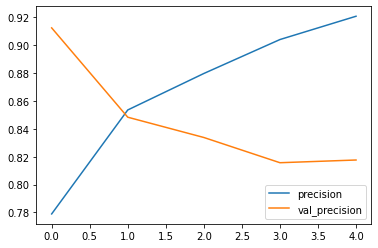

In [12]:
# Precision decreased but Recall increases
plt.plot(hist.history['precision'], label='precision')
plt.plot(hist.history['val_precision'], label='val_precision')
plt.legend()
plt.show()

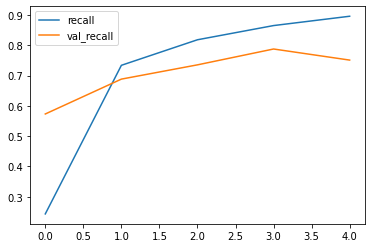

In [18]:
plt.plot(hist.history['recall'], label='recall')
plt.plot(hist.history['val_recall'], label='val_recall')
plt.legend()
plt.show()

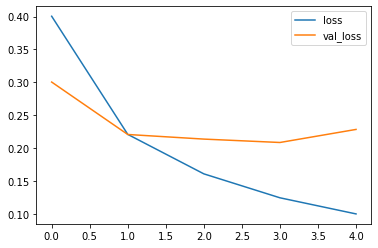

In [13]:
# Little bit of overfitting
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [14]:
# Evaluating the model on the test data
loss, prec, recall, auc = model.evaluate(testing_data['text'], testing_data['sentiment'], verbose=0)
print(f"loss: {loss}, \nprecision: {prec} \nrecall: {recall}\nAUC-ROC: {auc}")

loss: 0.25480514764785767, 
precision: 0.8950130939483643 
recall: 0.6987704634666443
AUC-ROC: 0.9390026330947876


In [15]:
# Testing a way to return predictions
def pred(text):

    # predict with model - will give float between 0 and 1
    pred_int = model.predict([text], verbose=0).round().item()

    # Return positve if 1, negative if 0
    pred_dict = {1:'Positive', 0:'Negative'}
    return pred_dict[pred_int]


In [16]:
print(pred('What an awful show'))
print(pred('What a great show'))

Negative
Positive


In [17]:
# Saving final model to serve with FAST API
model.save('sentiment_model/')

INFO:tensorflow:Assets written to: sentiment_model/assets
